In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import sys

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *


def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, 1, N_SOLUTIONS)



coords, deflection, boundary = read_data('../../../tractionforce/data/t2.txt')

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=10
condition_outside = (distances2d>10) * (distances2d<=CUTOFF+10)

del distances2d, mask, boundary2d
gc.collect()



6

In [3]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)


Size of the problem is 5183


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [4]:

obs_x_in = deflection[condition_inside]
obs_x_out = deflection[condition_outside]

n_in = len(x_in)
n_out = len(x_out)


gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma = Variable(n_in,2)
predicted_in_x = G_in_in_xx * sigma[:,0] + G_in_in_xy * sigma[:,1]
predicted_out_x = G_out_in_xx * sigma[:,0] + G_out_in_xy * sigma[:,1]
predicted_in_y = G_in_in_yx * sigma[:,0] + G_in_in_yy * sigma[:,1]
predicted_out_y = G_out_in_yx * sigma[:,0] + G_out_in_yy * sigma[:,1]

error = sum_squares(obs_x_in - predicted_in_x) + sum_squares(obs_x_out - predicted_out_x) #+ \
#    sum_squares(obs_y_in - predicted_in_y) + sum_squares(obs_y_out - predicted_out_y)

forceconstraints = [sum_entries(sigma[:,0])==0, sum_entries(sigma[:,1])==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma[:,1]) - mul_elemwise(y_in-y_center,sigma[:,0]))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [5]:
regularity_penalty = sum_entries(pnorm(sigma,2, axis=1))
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_values = []

u_x_values = []


In [6]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_values.append(sigma.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma[:,0].value.reshape((n_in,))
    s_y[condition_inside].flat = sigma[:,1].value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma[:,0].value, sigma[:,1].value]).T, error.value, regularity_penalty.value, val

    return np.array([s_x, s_y]).T,  error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
pad_results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  4e+01  1e+00
 1:  1.1739e-01  2.2973e-03  1e+02  2e+00  3e+00  1e-01
 2:  6.1519e-02  1.4981e-02  1e+01  4e-01  6e-01  6e-03
 3:  1.7629e-02  1.5069e-02  7e-02  3e-02  5e-02  2e-03
 4:  1.5167e-02  1.4803e-02  5e-03  8e-03  1e-02  8e-04
 5:  1.4830e-02  1.4678e-02  4e-03  7e-03  1e-02  8e-04
 6:  1.4737e-02  1.4648e-02  5e-04  1e-03  2e-03  1e-04
 7:  1.4670e-02  1.4624e-02  3e-04  9e-04  2e-03  8e-05
 8:  1.4617e-02  1.4608e-02  5e-05  2e-04  3e-04  2e-05
 9:  1.4612e-02  1.4608e-02  2e-05  8e-05  1e-04  7e-06
10:  1.4612e-02  1.4608e-02  2e-05  7e-05  1e-04  5e-06
11:  1.4610e-02  1.4608e-02  7e-06  2e-05  4e-05  2e-06
12:  1.4608e-02  1.4608e-02  7e-07  2e-06  4e-06  1e-07
13:  1.4608e-02  1.4608e-02  4e-08  1e-07  2e-07  9e-09
14:  1.4608e-02  1.4608e-02  7e-09  2e-08  4e-08  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00 

12:  1.5550e-02  1.5548e-02  8e-06  3e-05  5e-05  3e-06
13:  1.5549e-02  1.5549e-02  3e-06  9e-06  2e-05  8e-07
14:  1.5549e-02  1.5549e-02  1e-06  4e-06  7e-06  3e-07
15:  1.5549e-02  1.5549e-02  3e-07  1e-06  2e-06  7e-08
16:  1.5549e-02  1.5549e-02  3e-08  1e-07  2e-07  6e-09
17:  1.5549e-02  1.5549e-02  3e-09  1e-08  2e-08  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  4e+01  1e+00
 1:  2.5967e-01  6.3620e-03  2e+02  3e+00  6e+00  2e-01
 2:  6.2918e-02  1.6249e-02  4e+00  5e-01  8e-01  2e-02
 3:  1.8849e-02  1.6227e-02  7e-02  6e-02  1e-01  6e-03
 4:  1.7607e-02  1.6043e-02  5e-02  5e-02  8e-02  5e-03
 5:  1.5913e-02  1.5870e-02  3e-02  5e-02  8e-02  7e-03
 6:  1.6176e-02  1.5786e-02  4e-03  1e-02  2e-02  1e-03
 7:  1.5819e-02  1.5738e-02  2e-03  7e-03  1e-02  9e-04
 8:  1.5753e-02  1.5736e-02  4e-04  2e-03  3e-03  2e-04
 9:  1.5763e-02  1.5753e-02  2e-04  6e-04  1e-03  8e-05
10:  1.5763e-02  1.5758e-0

14:  1.8600e-02  1.8600e-02  1e-06  3e-06  4e-06  3e-07
15:  1.8601e-02  1.8601e-02  8e-08  2e-07  3e-07  2e-08
16:  1.8601e-02  1.8601e-02  9e-09  2e-08  4e-08  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  4e+01  1e+00
 1:  3.1480e-02 -1.2970e-01  1e+02  4e+00  8e+00  5e-01
 2:  5.6976e-02  1.6061e-02  3e+00  6e-01  1e+00  4e-02
 3:  1.8744e-02  1.7606e-02  6e-01  3e-01  4e-01  4e-02
 4:  1.2590e-02  1.8014e-02  5e-02  7e-02  1e-01  2e-02
 5:  1.2755e-02  1.8118e-02  2e-02  5e-02  8e-02  1e-02
 6:  1.6421e-02  1.8688e-02  5e-03  2e-02  3e-02  4e-03
 7:  1.8513e-02  1.9109e-02  1e-03  4e-03  7e-03  1e-03
 8:  1.8947e-02  1.9187e-02  8e-04  2e-03  4e-03  6e-04
 9:  1.9230e-02  1.9282e-02  2e-04  6e-04  1e-03  1e-04
10:  1.9274e-02  1.9290e-02  1e-04  4e-04  6e-04  7e-05
11:  1.9308e-02  1.9310e-02  2e-05  5e-05  9e-05  9e-06
12:  1.9312e-02  1.9313e-02  4e-06  1e-05  2e-05  2e-06
13:  1.9313e-02  1.9313e-0

 7:  3.0410e-02  3.0543e-02  4e-04  4e-04  7e-04  2e-04
 8:  3.0607e-02  3.0627e-02  7e-05  7e-05  1e-04  3e-05
 9:  3.0636e-02  3.0639e-02  1e-05  1e-05  2e-05  5e-06
10:  3.0641e-02  3.0642e-02  2e-06  2e-06  4e-06  9e-07
11:  3.0642e-02  3.0642e-02  4e-07  4e-07  6e-07  1e-07
12:  3.0642e-02  3.0642e-02  3e-08  3e-08  4e-08  9e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  3e+01  1e+00
 1: -6.0412e-01 -2.5607e-01  3e+01  2e+00  4e+00  7e-01
 2: -2.1475e-01 -4.1060e-02  5e-01  3e-01  4e-01  2e-01
 3: -9.4310e-03  1.6105e-02  6e-02  5e-02  8e-02  3e-02
 4:  1.8030e-02  2.7427e-02  2e-02  2e-02  3e-02  1e-02
 5:  2.5641e-02  3.0312e-02  1e-02  1e-02  2e-02  6e-03
 6:  3.1375e-02  3.2469e-02  3e-03  3e-03  4e-03  1e-03
 7:  3.2570e-02  3.2901e-02  1e-03  8e-04  1e-03  4e-04
 8:  3.3039e-02  3.3079e-02  1e-04  1e-04  2e-04  6e-05
 9:  3.3093e-02  3.3102e-02  3e-05  2e-05  4e-05  1e-05
10:  3.3107e-02  3.3108e-0

 1: -1.0862e+01 -4.8760e+00  9e+00  2e+00  1e+00  6e+00
 2: -7.7496e-02 -8.5012e-03  3e-01  5e-02  4e-02  8e-02
 3:  1.2928e-02  4.0619e-02  1e-01  2e-02  2e-02  3e-02
 4:  1.1832e-02  4.0378e-02  2e-01  2e-02  2e-02  3e-02
 5:  5.7051e-02  6.7257e-02  5e-02  9e-03  6e-03  1e-02
 6:  6.0991e-02  6.9348e-02  5e-02  8e-03  6e-03  9e-03
 7:  7.6504e-02  7.8877e-02  1e-02  2e-03  2e-03  3e-03
 8:  8.1140e-02  8.1592e-02  3e-03  5e-04  4e-04  5e-04
 9:  8.2101e-02  8.2173e-02  6e-04  9e-05  6e-05  8e-05
10:  8.2259e-02  8.2270e-02  1e-04  2e-05  1e-05  1e-05
11:  8.2287e-02  8.2288e-02  1e-05  2e-06  1e-06  1e-06
12:  8.2290e-02  8.2290e-02  2e-06  3e-07  2e-07  2e-07
13:  8.2290e-02  8.2290e-02  6e-07  8e-08  6e-08  5e-08
14:  8.2290e-02  8.2290e-02  1e-07  1e-08  1e-08  8e-09
15:  8.2290e-02  8.2290e-02  1e-08  2e-09  1e-09  8e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  1e+01  1e+00
 1: -1.6864e+01 -7.6433e+0

 5:  5.4514e-02  1.7110e-01  2e-01  8e-03  2e-03  1e-01
 6:  1.6807e-01  2.0976e-01  6e-02  3e-03  6e-04  4e-02
 7:  1.6976e-01  2.0857e-01  7e-02  3e-03  6e-04  4e-02
 8:  2.2076e-01  2.2685e-01  1e-02  5e-04  1e-04  6e-03
 9:  2.2773e-01  2.2903e-01  3e-03  1e-04  3e-05  1e-03
10:  2.2946e-01  2.2969e-01  6e-04  3e-05  5e-06  2e-04
11:  2.2979e-01  2.2981e-01  4e-05  2e-06  3e-07  1e-05
12:  2.2981e-01  2.2981e-01  2e-06  9e-08  2e-08  6e-07
13:  2.2981e-01  2.2981e-01  3e-07  1e-08  2e-09  8e-08
14:  2.2981e-01  2.2981e-01  8e-08  3e-09  6e-10  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  3e+03  2e+01  3e+00  1e+00
 1: -1.5357e+01 -6.9816e+00  5e+02  7e+00  1e+00  9e+00
 2: -7.4420e+00 -2.1687e+00  1e+01  4e-01  6e-02  5e+00
 3: -8.6689e-01 -1.9755e-01  1e+00  5e-02  8e-03  7e-01
 4:  5.8727e-02  1.7352e-01  2e-01  9e-03  1e-03  1e-01
 5:  1.8985e-01  2.2866e-01  1e-01  4e-03  6e-04  4e-02
 6:  1.8482e-01  2.2521e-0

 7:  4.3990e-01  4.4258e-01  2e+00  1e-02  5e-04  4e-03
 8:  4.3828e-01  4.4119e-01  2e+00  2e-02  6e-04  5e-03
 9:  4.5015e-01  4.5117e-01  9e-01  6e-03  3e-04  2e-03
10:  4.5362e-01  4.5457e-01  1e+00  7e-03  3e-04  2e-03
11:  4.8897e-01  4.8919e-01  2e-01  2e-03  7e-05  4e-04
12:  4.9686e-01  4.9692e-01  8e-02  5e-04  2e-05  1e-04
13:  4.9612e-01  4.9618e-01  8e-02  6e-04  2e-05  1e-04
14:  4.9858e-01  4.9860e-01  2e-02  2e-04  7e-06  4e-05
15:  4.9907e-01  4.9907e-01  7e-03  5e-05  2e-06  1e-05
16:  4.9927e-01  4.9927e-01  7e-04  5e-06  2e-07  1e-06
17:  4.9929e-01  4.9929e-01  6e-05  4e-07  2e-08  8e-08
18:  4.9929e-01  4.9929e-01  1e-06  8e-09  3e-10  2e-09
19:  4.9929e-01  4.9929e-01  5e-08  4e-10  2e-11  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  6e+03  2e+01  7e-01  1e+00
 1: -4.6124e-01 -1.2763e-01  2e+02  1e+00  4e-02  5e-01
 2:  4.9416e-02  6.8331e-02  1e+01  6e-02  2e-03  3e-02
 3:  2.4224e-02  4.3835e-0

 6:  5.0330e-01  5.0428e-01  7e+00  1e-02  1e-04  3e-03
 7:  5.0792e-01  5.0802e-01  7e-01  1e-03  1e-05  3e-04
 8:  5.0908e-01  5.0908e-01  1e-02  2e-05  2e-07  4e-06
 9:  5.0913e-01  5.0913e-01  1e-03  2e-06  2e-08  4e-07
10:  5.0913e-01  5.0913e-01  1e-05  2e-08  2e-10  4e-09
11:  5.0913e-01  5.0913e-01  1e-07  2e-10  7e-12  6e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  2e+04  2e+01  2e-01  1e+00
 1: -7.5512e-02 -6.8537e-02  2e+02  2e-01  2e-03  4e-02
 2:  2.3652e-01  2.3880e-01  5e+01  7e-02  6e-04  1e-02
 3:  3.9645e-01  3.9937e-01  5e+01  7e-02  6e-04  1e-02
 4:  4.0100e-01  4.0330e-01  3e+01  4e-02  3e-04  8e-03
 5:  4.8652e-01  4.8719e-01  8e+00  1e-02  9e-05  2e-03
 6:  5.0410e-01  5.0469e-01  6e+00  9e-03  7e-05  2e-03
 7:  5.0834e-01  5.0835e-01  1e-01  2e-04  2e-06  4e-05
 8:  5.0909e-01  5.0909e-01  6e-03  9e-06  7e-08  2e-06
 9:  5.0913e-01  5.0913e-01  1e-04  1e-07  1e-09  3e-08
10:  5.0913e-01  5.0913e-0

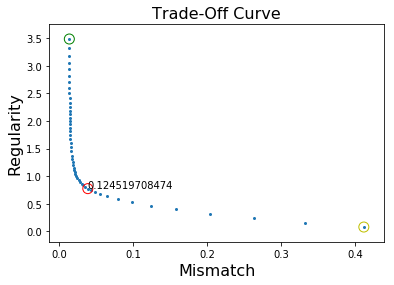

In [21]:
data_error = [res[1] for res in pad_results[:-12]]
reg_error = [res[2] for res in pad_results[:-12]]
lvals = [res[3] for res in pad_results[:-12]]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.scatter( data_error, reg_error,s=4)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

(119.94999999999999, 209.71000000000001)

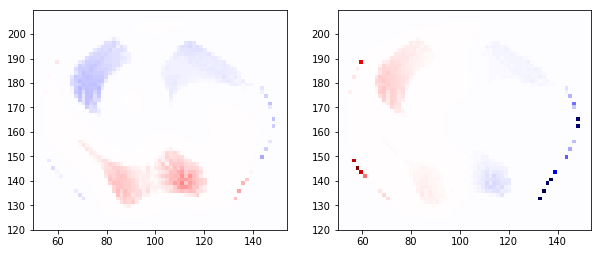

In [22]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[best][0][0][:,0]
s_y[condition_inside] = pad_results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

(119.94999999999999, 209.71000000000001)

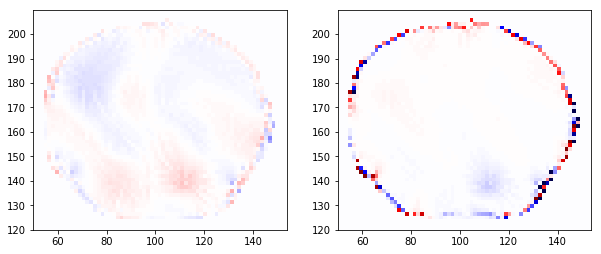

In [9]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[0][0][0][:,0]
s_y[condition_inside] = pad_results[0][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

(119.94999999999999, 209.71000000000001)

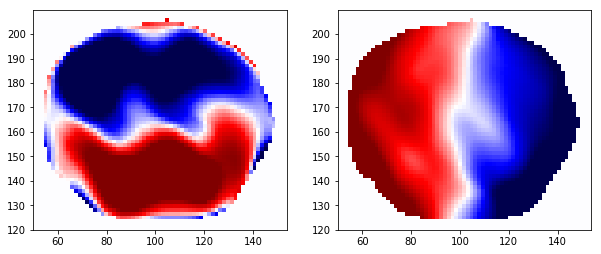

In [10]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[-1][0][0][:,0]
s_y[condition_inside] = pad_results[-1][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

(119.94999999999999, 209.71000000000001)

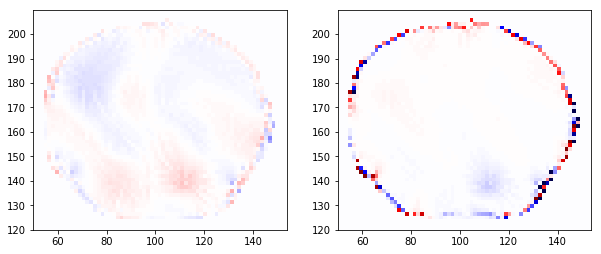

In [15]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[0][0][0][:,0]
s_y[condition_inside] = pad_results[0][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

(119.94999999999999, 209.71000000000001)

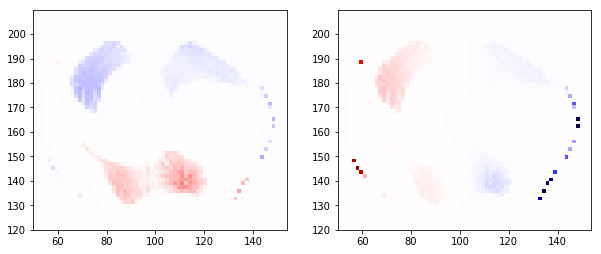

In [16]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[best][0][0][:,0]
s_y[condition_inside] = pad_results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

In [13]:
import pickle
import gzip

with gzip.open('../results/isotropic_L1_results_expanded_boundary.gz','wb') as f:
    pickle.dump(pad_results + [ [x_obs_positions,y_obs_positions]],f)

In [14]:
#import pickle
#import gzip

#results = pickle.load(gzip.open('results/trace_L1_results.gz','rb'))